In [26]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [27]:
import sys
sys.path.append("/home/rohit/PhD_Work/GM_my_version/Graph_matching/")
import os
from torch_geometric.datasets import TUDataset
import os.path as osp
from torch_geometric.loader import DenseDataLoader
from torch_geometric.nn import DenseSAGEConv, dense_diff_pool,dense_mincut_pool
import torch_geometric.transforms as T
from sklearn.cluster import KMeans
import networkx as nx
import numpy as np
from graph_generation.load_graphs_and_create_metadata import dataset_metadata
from graph_matching_tools.metrics import matching
import matplotlib.pyplot as plt
import scipy.io as sco
import slam.io as sio
from scipy.special import softmax
import pickle
from scipy.stats import betabinom
import seaborn as sns
import tools.graph_processing as gp
import tools.graph_visu as gv
from matplotlib.pyplot import figure
import pandas as pd
import random
from torch_geometric.utils.convert import from_networkx
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch.nn.functional import one_hot
from sklearn.preprocessing import OneHotEncoder
from torch.nn import Linear,BatchNorm1d
import torch.nn.functional as F
from math import ceil
import torch_geometric as pyg
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import TopKPooling
from torch_geometric.data import Data
from torch_geometric.loader import DenseDataLoader
from torch.nn.utils.rnn import pad_sequence
from torch_geometric.utils import to_dense_batch, to_dense_adj
from torch_geometric.nn import GCNConv, DenseGraphConv
%matplotlib inline

In [28]:
path_trials = '..//data/simu_graph/Simu_high_noise_given_ref_k_1000/'
path_sub_dir = '/noise_400,outliers_varied/graphs/'
all_trials = np.sort(list(map(int,os.listdir(path_trials)))) # all trials

In [ ]:
# def update_G(g):
    
#     adj_ident = nx.from_numpy_matrix(np.identity(len(g)))
#     g_diag = nx.from_numpy_matrix(np.identity(len(g)))
#     edge_list_iden = list(g_diag.edges)
#     g.remove_edges_from(list(g.edges))
#     g.add_edges_from(edge_list_iden)

In [30]:
all_graphs_same_trial = []
all_graphs_labels_same_trial = []

referene_graphs = []

for trial in all_trials:
    
    referene_graphs.append(nx.read_gpickle(path_trials + str(trial) + '/reference_'+ str(trial) +'.gpickle'))
    
    trial_folder = path_trials + str(trial) + path_sub_dir
    all_graphs_same_trial.append(gp.load_graphs_in_list(trial_folder)) # append graphs
    all_graphs_labels_same_trial.append(np.ones([len(gp.load_graphs_in_list(trial_folder))])*trial) # append corr lab

In [31]:
# taking 300 graph from each population for learning 

simu_train_set = []
simu_train_labels = []

for graph_set,graph_labels in zip(all_graphs_same_trial,all_graphs_labels_same_trial):
    simu_train_set.extend(graph_set[:300])
    simu_train_labels.extend(graph_labels[:300])

In [32]:
def graph_remove_dummy_nodes(graph):
    nodes_dummy_true = [x for x,y in graph.nodes(data=True) if y['is_dummy']==True]
    graph.remove_nodes_from(nodes_dummy_true)
    #print(len(graph.nodes))

In [33]:
# Convert networkx graphs to pyg graphs

sulcal_simu_dataset = []

sulc_ident = []

for i,g in enumerate(simu_train_set):
    #graph_remove_dummy_nodes(g) # remove dummy nodes
    #g.remove_edges_from(nx.selfloop_edges(g)) # remove self loop edges
    
    #update_G(g) # create identity adjacency matrix
    
    sulc_ident.append(g)
    
    attr_coords = np.array(list(nx.get_node_attributes(g,'coord').values())) #simu attribute (coords)
    
    x = torch.tensor(attr_coords,dtype=torch.float)
    
    #adj = torch.tensor(nx.adjacency_matrix(g).todense(),dtype=torch.float)
    
    y = torch.tensor(simu_train_labels[i],dtype=torch.long) # add graph label
    edge_index = torch.tensor(list(g.edges))
    
    sulcal_simu_dataset.append(Data(x=x, y=y, edge_index=edge_index.t().contiguous())) #

/tmp/ipykernel_30601/3892663140.py:21: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(simu_train_labels[i],dtype=torch.long) # add graph label


In [34]:
random.shuffle(sulcal_simu_dataset)

train_dataset = sulcal_simu_dataset[:len(sulcal_simu_dataset)-100]
test_dataset = sulcal_simu_dataset[len(sulcal_simu_dataset)-100:]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # dense data loader for using adjacency
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [35]:
num_node_features = train_dataset[0].num_features
num_node_features

3

In [36]:
# # Create GAT Model

# class MLP(torch.nn.Module):
#     def __init__(self, in_channels, out_channels, hidden_channels=16):        
#         super(MLP, self).__init__()
#         torch.manual_seed(12345)
        
#         self.emb_dim = 8
        
#         self.lin1 = Linear(in_channels, hidden_channels)
#         self.lin2 = Linear(hidden_channels, hidden_channels)
#         self.lin3 = Linear(hidden_channels, out_channels)
        

#     def forward(self, x, edge_index, batch):
#         # 1. Obtain node embeddings 
        
#         emb = self.lin1(x)
#         x = emb.relu()
#         emb = self.lin2(x)
#         x = emb.relu()
#         g_emb = global_mean_pool(x, batch)
#         out = self.lin3(g_emb)
        
#         return out, g_emb, emb, x

    
# model = MLP(num_node_features, len(all_trials))
# print(model)

In [37]:
# # Create GAT Model

# class GAT(torch.nn.Module):
#     def __init__(self, in_channels, out_channels, hidden_channels=32):        
#         super(GAT, self).__init__()
#         torch.manual_seed(12345)
#         self.in_head = 2
#         self.out_head = 1
        
#         self.emb_dim = 8
        
        
#         self.conv1 = GATConv(in_channels, hidden_channels, heads=self.in_head)
#         self.conv2 = GATConv(hidden_channels*self.in_head, hidden_channels,concat=False)
#         self.conv3 = GATConv(hidden_channels, self.emb_dim, concat=False, dropout=0.6)
#         self.lin = Linear(self.emb_dim, out_channels)
        

#     def forward(self, x, edge_index, batch):
#         # 1. Obtain node embeddings 
#         x = self.conv1(x, edge_index)
#         x = x.relu()
#         x = self.conv2(x, edge_index)
#         x = x.relu()
#         emb,attn_weights = self.conv3(x, edge_index,return_attention_weights=True)

#         # 2. Readout layer
#         g_emb = global_mean_pool(emb, batch)  # [batch_size, hidden_channels] TopKPooling
#         #g_emb = TopKPooling(emb, batch)

#         # 3. Apply a final classifier
#         out = F.dropout(g_emb, p=0.5, training=self.training)
#         out = self.lin(out)
        
#         return out, g_emb, emb, attn_weights

    
# model = GAT(num_node_features, len(all_trials))
# print(model)

In [38]:
class mincutnet(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=32):
        super(mincutnet, self).__init__()
        
        self.in_head = 1
        self.out_head = 1
        
        self.emb_dim = 16 # embedding dimension
        
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, self.emb_dim, heads=self.in_head,dropout=0.2)

#        self.conv3 = GATConv(hidden_channels, self.emb_dim, concat=False, dropout=0.6)
        
        num_of_centers =  22
        self.pool1 = Linear(self.emb_dim, num_of_centers) # The degree of the node belonging to any of the centers
        
        self.conv3 = DenseGraphConv(self.emb_dim, self.emb_dim)

        #self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(self.emb_dim, out_channels)

    def forward(self, x, edge_index, batch): 
        
        x = F.relu(self.conv1(x, edge_index))
        #x = F.relu(self.conv2(x, edge_index))
        node_emb, attn_weights = self.conv2(x, edge_index,return_attention_weights=True)
        x = node_emb.relu()

        x, mask = to_dense_batch(x, batch) 
        
        adj = to_dense_adj(edge_index, batch) 
        s = self.pool1(x)

        
        x, adj, mincut_loss, ortho_loss = dense_mincut_pool(x, adj, s, mask) 
        x = self.conv3(x, adj) 
        g_emb = x.mean(dim=1) 
        #x = F.relu(self.lin1(x)) 
        out = self.lin2(g_emb)
        return out, g_emb, node_emb, attn_weights

model = mincutnet(num_node_features, len(all_trials))
print(model)

mincutnet(
  (conv1): GCNConv(3, 32)
  (conv2): GATConv(32, 16, heads=1)
  (pool1): Linear(in_features=16, out_features=22, bias=True)
  (conv3): DenseGraphConv(16, 16)
  (lin2): Linear(in_features=16, out_features=2, bias=True)
)


In [39]:
#model = GCN(hidden_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    
    for data in train_loader:# Iterate in batches over the training dataset.
        out, g_emb, node_emb, s = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out, g_emb, node_emb, s =  model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
        
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [40]:
train_acc_lst = []
test_acc_lst = []
for epoch in range(1, 99):
    train()
    train_acc = test(train_loader)
    train_acc_lst.append(train_acc)
    test_acc = test(test_loader)
    test_acc_lst.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.5120, Test Acc: 0.4400
Epoch: 002, Train Acc: 0.4880, Test Acc: 0.5600
Epoch: 003, Train Acc: 0.5120, Test Acc: 0.4400
Epoch: 004, Train Acc: 0.4860, Test Acc: 0.5600
Epoch: 005, Train Acc: 0.4300, Test Acc: 0.5800
Epoch: 006, Train Acc: 0.4860, Test Acc: 0.4700
Epoch: 007, Train Acc: 0.4580, Test Acc: 0.4700
Epoch: 008, Train Acc: 0.4500, Test Acc: 0.5600
Epoch: 009, Train Acc: 0.4680, Test Acc: 0.5200
Epoch: 010, Train Acc: 0.5020, Test Acc: 0.5200
Epoch: 011, Train Acc: 0.5460, Test Acc: 0.4800
Epoch: 012, Train Acc: 0.5620, Test Acc: 0.5800
Epoch: 013, Train Acc: 0.5860, Test Acc: 0.5800
Epoch: 014, Train Acc: 0.5720, Test Acc: 0.5600
Epoch: 015, Train Acc: 0.5780, Test Acc: 0.5600
Epoch: 016, Train Acc: 0.5860, Test Acc: 0.5700
Epoch: 017, Train Acc: 0.5680, Test Acc: 0.5800
Epoch: 018, Train Acc: 0.5740, Test Acc: 0.5600
Epoch: 019, Train Acc: 0.5720, Test Acc: 0.5600
Epoch: 020, Train Acc: 0.5780, Test Acc: 0.5400
Epoch: 021, Train Acc: 0.5880, Test Acc:

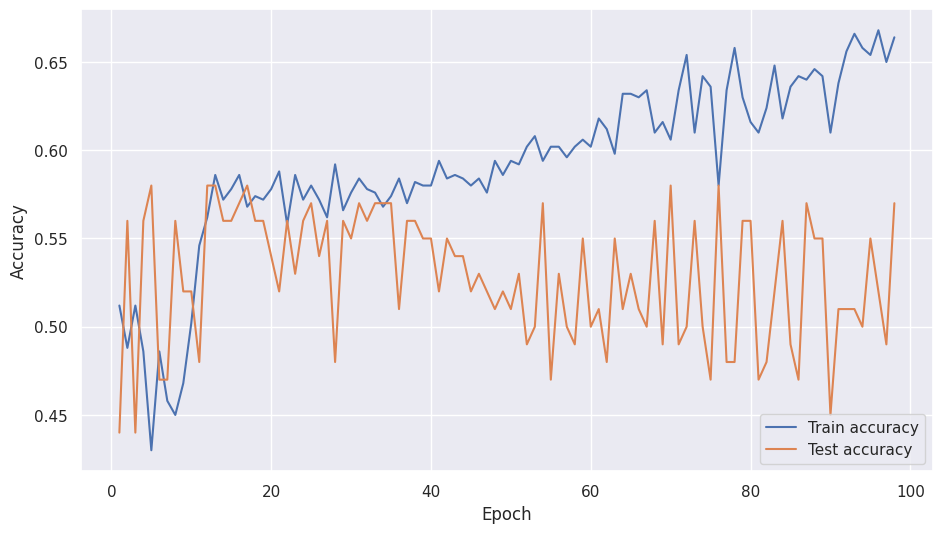

In [41]:
sns.set(rc={'figure.figsize':(11,6)})
epochs = np.arange(1,99,1)
plt.plot(epochs, train_acc_lst,label='Train accuracy')
plt.plot(epochs, test_acc_lst, label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")

### Evaluate on a seperate set

In [42]:
# taking rest graph from each population as evaluation set

simu_eval_set = []
simu_eval_labels = []

for graph_set,graph_labels in zip(all_graphs_same_trial,all_graphs_labels_same_trial):
    simu_eval_set.extend(graph_set[300:])
    simu_eval_labels.extend(graph_labels[300:])

In [43]:
eval_set = []

for i,g in enumerate(simu_eval_set):
    graph_remove_dummy_nodes(g) # remove dummy nodes
#     g.remove_edges_from(nx.selfloop_edges(g)) # remove self loop edges
    #update_G(g)
    
    attr_coords = np.array(list(nx.get_node_attributes(g,'coord').values())) #simu attribute (coords) 
    x = torch.tensor(attr_coords,dtype=torch.float)

    #x = torch.tensor(nx.adjacency_matrix(g).todense(),dtype=torch.float)
    
    y = torch.tensor(simu_eval_labels[i],dtype=torch.long) # add graph label
    edge_index = torch.tensor(list(g.edges))
    
    eval_set.append(Data(x=x, y=y, edge_index=edge_index.t().contiguous()))

/tmp/ipykernel_30601/2514723297.py:13: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(simu_eval_labels[i],dtype=torch.long) # add graph label


In [44]:
# reference_set = []
# reference_label = list(np.arange(0,10,1))

# for i,g in enumerate(referene_graphs):
#     #graph_remove_dummy_nodes(g) 
#     #g.remove_edges_from(nx.selfloop_edges(g)) 
    
#     update_G(g)
    
#     attr_coords = np.array(list(nx.get_node_attributes(g,'coord').values())) #simu attribute (coords) 
#     x = torch.tensor(attr_coords,dtype=torch.float)
    
#     y = torch.tensor(reference_label[i],dtype=torch.long) # add graph label
#     edge_index = torch.tensor(list(g.edges))
    
#     reference_set.append(Data(x=x, y=y, edge_index=edge_index.t().contiguous()))

In [45]:
# eval emb mixed with reference graph
#all_graph = DataLoader(eval_set+reference_set, batch_size= len(eval_set) + len(reference_set), shuffle=False)
all_graph = DataLoader(eval_set, batch_size= len(eval_set), shuffle=False)

for data in all_graph:
      out, g_emb, node_emb, s = model(data.x, data.edge_index, data.batch)
#   prob,g_emb,out_emb,attn_weights = model(data.x, data.edge_index, data.batch) o


#out_emb = out_emb.detach().numpy()
g_emb = g_emb.detach().numpy()

In [46]:
def get_labels_from_k_means(k, coords):
    
    kmeans = KMeans(n_init= 'auto',n_clusters=k, random_state=0).fit(coords)
    
    return kmeans,kmeans.labels_

In [47]:
k = 2
kmeans,kmeans_labels = get_labels_from_k_means(k, g_emb[:400])

In [48]:
all_emb = np.concatenate((g_emb,kmeans.cluster_centers_),axis=0)

In [49]:
from sklearn.manifold import TSNE
import pandas as pd

n_components = 2
tsne = TSNE(n_components)

tsne_graph = tsne.fit_transform(all_emb)
tsne_graph.shape

(402, 2)

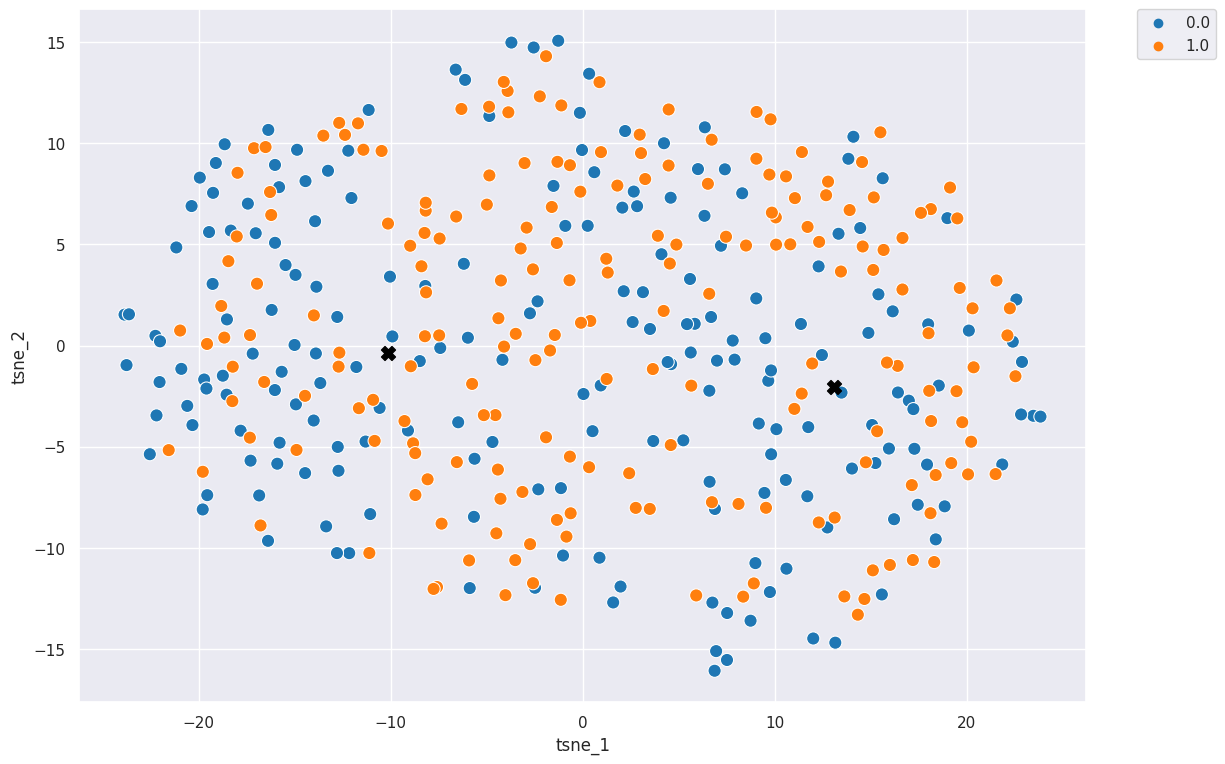

In [50]:
sns.set(rc={'figure.figsize':(13,9)})

tsne_graph_df = pd.DataFrame({'tsne_1': tsne_graph[:400,0], 'tsne_2': tsne_graph[:400,1], 'label':simu_eval_labels})
#tsne_ref_df = pd.DataFrame({'tsne_1': tsne_graph[2000:2010,0], 'tsne_2': tsne_graph[2000:2010,1], 'label':reference_label})
tsne_kmeans_df = pd.DataFrame({'tsne_1': tsne_graph[400:,0], 'tsne_2': tsne_graph[400:,1],'label':[0,1]})

fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_graph_df, ax=ax,s=90,palette='tab10')
#sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_ref_df, ax=ax,s=150,palette='tab10',markers='label')
plt.scatter(tsne_kmeans_df['tsne_1'], tsne_kmeans_df['tsne_2'], c='black', s = 100, marker='X')

# lim = (tsne_graph.min()-5, tsne_graph.max()+5)
# ax.set_xlim(lim)
# ax.set_ylim(lim)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

### Compare with classical methods on simulations

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(g_emb[:2000], simu_eval_labels, test_size=0.6, random_state=42)

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
clf_svm = SVC(gamma='auto',kernel='linear').fit(X_train, y_train)
clf_svm.score(X_test, y_test)

In [ ]:
clf_rf = RandomForestClassifier(max_depth = 5,random_state=0).fit(X_train, y_train)
clf_rf.score(X_test, y_test)

In [ ]:
# On coordinates

In [ ]:
avg_feature_coords = []

for d in eval_set:
    avg_feature_coords.append(np.mean(d.x.detach().numpy(),axis=0))
    
avg_feature_coords = np.array(avg_feature_coords)

In [ ]:
X_train_coords, X_test_coords, y_train_coords, y_test_coords = train_test_split(avg_feature_coords, simu_eval_labels, test_size=0.6, random_state=42)

In [ ]:
clf_coord = LogisticRegression(random_state=0).fit(X_train_coords, y_train_coords)
clf_coord.score(X_test_coords, y_test_coords)

In [ ]:
clf_svm_coord = SVC(gamma='auto',kernel='linear').fit(X_train_coords, y_train_coords)
clf_svm_coord.score(X_test_coords, y_test_coords)

In [ ]:
clf_rf_coord = RandomForestClassifier(max_depth = 5,random_state=0).fit(X_train_coords, y_train_coords)
clf_rf_coord.score(X_test_coords, y_test_coords)